In [1]:
%autoreload 2
%matplotlib inline

/home/micha/work/occrp/followthemoney-predict/experiments/xref-experiments/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:280: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  import matplotlib


In [2]:
from pathlib import Path
import json

import pandas as pd

import torch
from xref_experiments.model import PropertySkipgramModel
from xref_experiments.create_model_data import load_vocabularies, ParquetModelData

In [3]:
import pylab as py
import seaborn as sns

In [4]:
data_dir = Path("/scratch/xref-experiments.bak/")
vocabularies = load_vocabularies(data_dir / 'vocabulary')
data = ParquetModelData(data_dir / 'model-data', "r", vocabularies=vocabularies).open()

In [5]:
history = []
with open('../property_skipgram_100epoch_1024_history.json') as fd:
    history_data = json.loads(fd.read())
for phase, items in history_data.items():
    for metric, values in items.items():
        for epoch, value in enumerate(values):
            history.append({'phase': phase, 'metric': metric, 'value': value, 'epoch': epoch})
history = pd.DataFrame.from_dict(history)

In [6]:
model = PropertySkipgramModel(data, n_embed=1024)
model.load_state_dict(torch.load('../property_skipgram_100epoch_1024.tch'))

<All keys matched successfully>

In [7]:
history.head()

,phase,metric,value,epoch
0,train,loss,0.116905,0
1,train,loss,0.113184,1
2,train,loss,0.112998,2
3,train,loss,0.112954,3
4,train,loss,0.112912,4


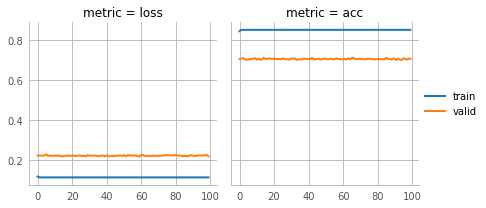

In [8]:
g = sns.FacetGrid(history, col="metric")
g.map_dataframe(sns.lineplot, x='epoch', y='value', hue='phase')
g.add_legend()

In [9]:
df = next(data.skipgrams('test', batch_size=65536))

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65536 entries, 1707946 to 2593897
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_x        65536 non-null  object 
 1   schema_x    65536 non-null  uint8  
 2   group_x     65536 non-null  uint8  
 3   property_x  65536 non-null  uint16 
 4   ngrams_x    65536 non-null  object 
 5   schema_y    65536 non-null  uint8  
 6   group_y     65536 non-null  uint8  
 7   property_y  65536 non-null  uint16 
 8   ngrams_y    65536 non-null  object 
 9   id_y        65536 non-null  object 
 10  target      65536 non-null  int64  
 11  rnd_x       32881 non-null  float64
 12  rnd_y       32881 non-null  float64
dtypes: float64(2), int64(1), object(4), uint16(2), uint8(4)
memory usage: 4.5+ MB


In [11]:
df['predict'] = model(df).detach().numpy()
df['predict_class'] = (df['predict'] > 0.5).astype('int')
df['correct'] = (df['target'] == df['predict_class']).astype('int')

/home/micha/work/occrp/followthemoney-predict/experiments/xref-experiments/xref_experiments/model.py:63: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  .map(lambda n: torch.as_tensor(n, device=self.device))


In [12]:
pd.crosstab(df['target'], df['predict_class'], normalize='columns')

predict_class,0,1
target,,
0,0.654122,0.244411
1,0.345878,0.755589


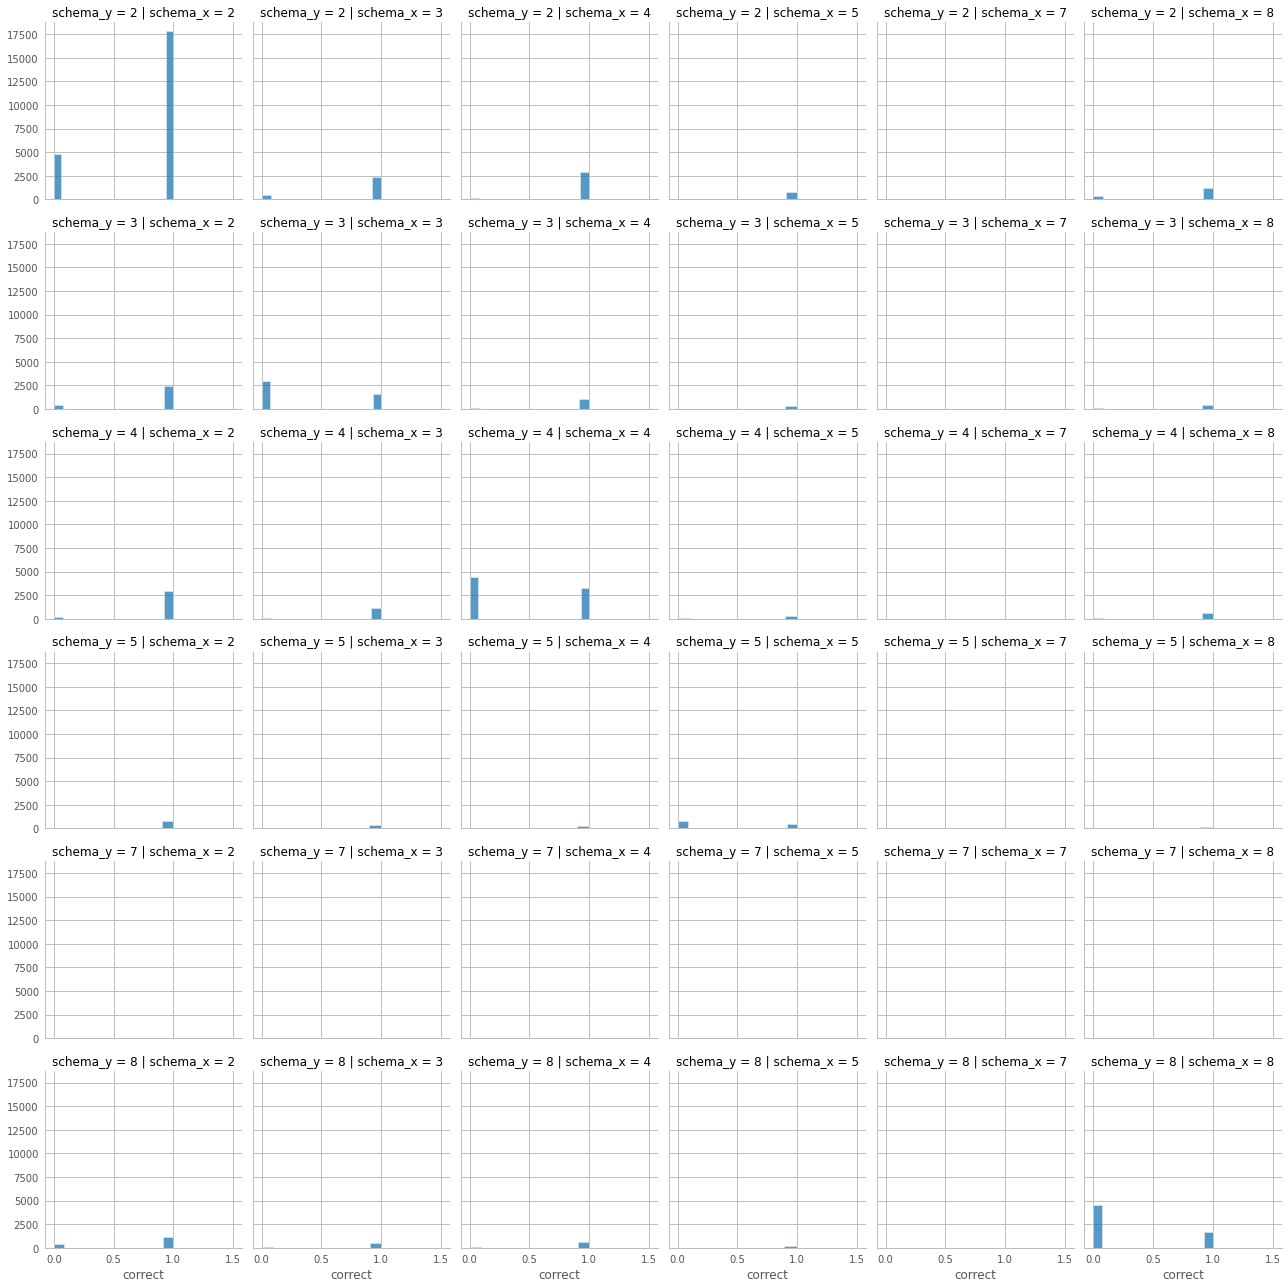

In [14]:
g = sns.FacetGrid(df, col="schema_x", row='schema_y')
g.map_dataframe(sns.histplot, 'correct')
#g.add_legend()

In [69]:
d = df.query('schema_x == 2').head(500)
#d[['ngrams_x', 'ngrams_y']] = d[['ngrams_x', 'ngrams_y']].applymap(data.vocabularies['ngrams'].invert)
d[['schema_x', 'schema_y']] = d[['schema_x', 'schema_y']].applymap(data.vocabularies['schema'].invert)
d[['group_x', 'group_y']] = d[['group_x', 'group_y']].applymap(data.vocabularies['group'].invert)
d[['property_x', 'property_x']] = d[['property_x', 'property_x']].applymap(data.vocabularies['property'].invert)
d.head(50)

,id_x,schema_x,group_x,property_x,ngrams_x,schema_y,group_y,property_y,ngrams_y,id_y,target,rnd_x,rnd_y,predict,predict_class,correct
1707946,0cdd6fbeb99c3a0421db2698affb07efa64c85a2.67fc1...,[Person],[name],[alias],"[1433, 65, 421, 201, 142, 694, 3, 529, 201, 14...",[Person],[name],2,"[1699, 37, 3, 2621, 649, 13558, 13050, 11402]",2333367a3a7987f5ccf922448f141181a4ea7bc9.acb9b...,0,40584.0,62278.0,0.910631,1,0
4931644,21033c3acea294468fdcbfde15ebdb89f810cf64.d383b...,[Person],[string],[gender],[2096],[Person],[identifier],12,"[3594, 3798, 3159, 3618, 2304, 2578, 390, 2686...",21033c3acea294468fdcbfde15ebdb89f810cf64.d383b...,1,NaN,NaN,0.645869,1,1
3895009,05ba6fc8bf742f17f4b3f75d7b0e2760166d91d5.efcee...,[Person],[address],[address],"[156, 3401, 1407, 4892, 5720, 2360, 5121, 847,...",[Company],[identifier],9,"[4990, 668, 5913, 5801, 3635, 634, 199, 86, 51...",11103c2a0d9c7b9aabaef8b2be15f89b2cabbefc.99f8d...,0,64808.0,21007.0,0.313687,0,1
34105,0319b07e7a3c821fcde77cfa238b4109cd619f24.4cd9f...,[Person],[text],[notes],"[834, 745, 509, 33315]",[Person],[country],20,[482],0319b07e7a3c821fcde77cfa238b4109cd619f24.4cd9f...,1,NaN,NaN,0.991222,1,1
4433143,033436c9dd26d7e0c4cd5a8593877663afd22636.421a6...,[Person],[address],[address],"[547, 131, 412, 1057, 986, 2528, 3888, 2609, 9...",[Person],[name],2,"[5087, 2556, 5753, 2337]",0916c2aa0df330692e9da62525eb35e69bd1c538.ea6ec...,0,40482.0,20793.0,-0.012176,0,1
276595,0e1da5c986ef6edbf95e8a65649d85861538dcb6.4a517...,[Person],[string],[position],"[624, 425, 101, 3, 655, 64, 854, 101, 3, 300, ...",[Person],[string],29,"[1129, 1219, 100, 568, 738, 921, 929, 341, 932...",0b3b0f52f3133940424d53a459a2eef131a0ccfe.5d310...,0,8066.0,59685.0,0.981620,1,0
3919214,1eabfc807b5950aafa439782f35682a55f80bee8.4e122...,[Person],[string],[birthPlace],"[508, 1023, 451]",[RealEstate],[identifier],16,"[656, 218, 422, 222, 456, 81, 2, 500, 683, 25,...",1404c876e864f6053f6c9f708205b95a0b26b343,0,52095.0,53072.0,-0.060278,0,1
5125792,2297b5a5bae9243cb49ec5fefb379d60568b964c.b76a3...,[Person],[identifier],[idNumber],"[706, 466, 232, 1549, 2112, 3255, 1231, 3135, ...",[Person],[address],3,"[2258, 2219, 2123, 11032, 496, 2448, 198, 216,...",2297b5a5bae9243cb49ec5fefb379d60568b964c.b76a3...,1,NaN,NaN,0.886594,1,1
1420410,224a45501a7bc9edf52b82423f2611b8fd3083be.44f96...,[Person],[name],[alias],"[12049, 2556, 4114, 1613, 1644, 2426, 684, 6993]",[Person],[name],2,"[2191, 3417, 1301, 807, 115, 1707, 783, 875, 2...",07e972dd79a7e6efc044ebc7379bc0cf98578df4.6a0fe...,0,31897.0,7009.0,0.053954,0,1
3427781,0e8bdcb34ca89c1f5e85fa14f683104a4ac29ae8.0d406...,[Person],[string],[position],"[12, 15, 327, 8, 1287, 1767, 4293, 1090, 887, ...",[Person],[string],19,"[624, 425, 101, 3, 655, 64, 854, 101, 3, 300, ...",0e8bdcb34ca89c1f5e85fa14f683104a4ac29ae8.0d406...,1,NaN,NaN,0.970547,1,1


In [74]:
result = model.property_embedding.similar(torch.as_tensor(d.ngrams_x.iloc[0]),
                                          pool=d.ngrams_x.map(torch.as_tensor).to_list())
result

torch.return_types.topk(
values=tensor([1.0000, 0.9631, 0.9597, 0.9552, 0.9544, 0.9542, 0.9510, 0.9483, 0.9459,
        0.9457], grad_fn=<TopkBackward>),
indices=tensor([  0, 303, 232, 214, 394, 112, 231,  69, 163,  23]))

In [76]:
d.iloc[result.indices].head()

,id_x,schema_x,group_x,property_x,ngrams_x,schema_y,group_y,property_y,ngrams_y,id_y,target,rnd_x,rnd_y,predict,predict_class,correct
1707946,0cdd6fbeb99c3a0421db2698affb07efa64c85a2.67fc1...,[Person],[name],[alias],"[1433, 65, 421, 201, 142, 694, 3, 529, 201, 14...",[Person],[name],2,"[1699, 37, 3, 2621, 649, 13558, 13050, 11402]",2333367a3a7987f5ccf922448f141181a4ea7bc9.acb9b...,0,40584.0,62278.0,0.910631,1,0
1258899,1d87382e4a92da3ee410d655e800e0118ddc1595.5ae2f...,[Person],[string],[position],"[134, 45, 37, 787, 784, 681, 516, 2355, 523, 7...",[Vehicle],[string],2,"[11634, 10815, 5657, 14782, 16791, 6408, 10195...",0e10c27dbb20d1f8a95fdcaceba741330e6ef771.3b52b...,0,43781.0,3268.0,0.003681,0,1
5228608,23743df26945524951e7777b4b2ebcc97ce6b28f.d03a1...,[Person],[string],[position],"[134, 45, 37, 787, 784, 681, 516, 855, 596, 55...",[Person],[string],29,"[215, 2076, 1439, 4193]",23743df26945524951e7777b4b2ebcc97ce6b28f.d03a1...,1,NaN,NaN,0.938921,1,1
874056,0d6c4dc27355d9947ee557ce71939668020904e7.5197f...,[Person],[string],[position],"[2177, 528, 37, 3, 2621, 427, 9344, 299, 1114,...",[Person],[string],5,"[3107, 2554, 116]",033041546a2d5e0413af050a73911bfc549dc95f.a946d...,0,17892.0,49117.0,-0.054757,0,1
2577515,0b9527faf5388aecddf1d3d85f264cc37a3ceeed.2ab32...,[Person],[string],[position],"[134, 45, 37, 787, 784, 681, 516, 763, 193, 17...",[Person],[string],29,"[215, 2076, 1439, 4193]",0b9527faf5388aecddf1d3d85f264cc37a3ceeed.2ab32...,1,NaN,NaN,0.908162,1,1


In [45]:
torch.cosine_similarity(a.view(1, -1), b)

tensor([0.9746, 0.7857])